# 2. Modeling

### 2.0 Load Train, Val, Test (Numpy Array)

- Gray Scale : Data_gray 폴더 안에 .npy 파일이 있으면 된다.
- RGB Scale : Data 폴더 안에 .npy 파일이 있으면 된다.

#### Scale 설정
- scale = 'gray'
- scale = 'rgb'

In [12]:
scale = 'rgb'
data_dir = 'Data_class_drop_4'
channel = 3

In [13]:
!ls {data_dir}

X_test.npy  X_train.npy  X_val.npy  y_test.npy	y_train.npy  y_val.npy


#### Load Data

In [14]:
import os
import numpy as np

if os.path.exists(data_dir):
    X_train = np.load(data_dir + '/X_train.npy')
    y_train = np.load(data_dir + '/y_train.npy')
    X_val = np.load(data_dir + '/X_val.npy')
    y_val = np.load(data_dir + '/y_val.npy')
    X_test = np.load(data_dir + '/X_test.npy')
    y_test = np.load(data_dir + '/y_test.npy')

    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    print(X_test.shape, y_test.shape)

(210, 64, 128, 128, 3) (210, 4)
(70, 64, 128, 128, 3) (70, 4)
(70, 64, 128, 128, 3) (70, 4)


### 2.1 VGG16 + LSTM

#### 모델 이름 설정

In [15]:
model_name = 'vgg16_lstm_class_drop'

#### Parameters

In [16]:
epochs = 10
batch_size = 2

### 2.1.1 Model Define

In [17]:
frames = 64
width = 128
height = 128

classes = 4

In [18]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam

video = Input(shape=(frames,
                     width,
                     height,
                     channel))

cnn_base = VGG16(input_shape=(width,
                              height,
                              channel),
                 weights="imagenet",
                 include_top=False)
cnn_out = GlobalAveragePooling2D()(cnn_base.output)

cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
cnn.trainable = False

encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(256)(encoded_frames)

hidden_layer = Dense(units=1024, activation="relu")(encoded_sequence)

outputs = Dense(units=classes, activation="softmax")(hidden_layer)

model = Model(inputs=[video], outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 128, 128, 3)] 0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 512)           14714688  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 15,769,412
Trainable params: 1,054,724
Non-trainable params: 14,714,688
_________________________________________________________________


### 2.1.2 Model Compile

In [19]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

### 2.1.3 Model Fit

In [20]:
%%time

History = model.fit(X_train, y_train,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data = (X_val, y_val))

Epoch 1/10
105/105 [==============================] - 673s 6s/step - loss: 1.3111 - accuracy: 0.4627 - val_loss: 1.0037 - val_accuracy: 0.5286
Epoch 2/10
105/105 [==============================] - 745s 7s/step - loss: 0.7179 - accuracy: 0.7351 - val_loss: 1.0725 - val_accuracy: 0.6286
Epoch 3/10
105/105 [==============================] - 750s 7s/step - loss: 0.6393 - accuracy: 0.7274 - val_loss: 1.6545 - val_accuracy: 0.5000
Epoch 4/10
105/105 [==============================] - 762s 7s/step - loss: 0.4421 - accuracy: 0.8253 - val_loss: 1.4939 - val_accuracy: 0.5286
Epoch 5/10
105/105 [==============================] - 775s 7s/step - loss: 0.2320 - accuracy: 0.8992 - val_loss: 1.9230 - val_accuracy: 0.5714
Epoch 6/10
105/105 [==============================] - 780s 7s/step - loss: 0.0998 - accuracy: 0.9590 - val_loss: 2.0499 - val_accuracy: 0.5571
Epoch 7/10
105/105 [==============================] - 779s 7s/step - loss: 0.1652 - accuracy: 0.9647 - val_loss: 2.2512 - val_accuracy: 0.5857

### 2.1.4 Fitted Model Visualization

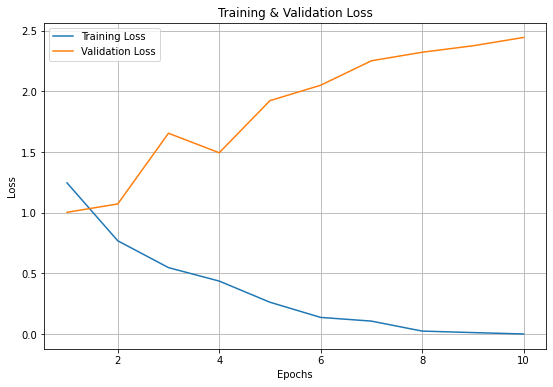

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(History.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History.history['loss'])
plt.plot(epochs, History.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

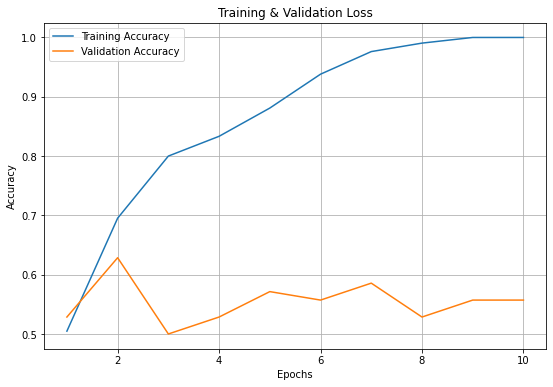

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(History.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History.history['accuracy'])
plt.plot(epochs, History.history['val_accuracy'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

### 2.1.5 Model Evaluate

In [23]:
loss, accuracy = model.evaluate(X_test, y_test,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

35/35 [==============================] - 192s 5s/step - loss: 1.8132 - accuracy: 0.5857
Loss = 1.81317
Accuracy = 0.58571


### 2.1.6 Model Save

In [24]:
save_dir = 'Models'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

final_model_name = '/' + scale + '_' + model_name + '.h5'

model.save(save_dir + final_model_name)

### 2.1.7 Saved Model Test

In [25]:
from keras.models import load_model

rgb_cnn_lstm = load_model(save_dir + final_model_name)

loss, accuracy = rgb_cnn_lstm.evaluate(X_test, y_test,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

35/35 [==============================] - 191s 5s/step - loss: 1.8132 - accuracy: 0.5857
Loss = 1.81317
Accuracy = 0.58571
